In [64]:
import enum
import random

import matplotlib.pyplot as plt
import numpy as np

In [65]:
# cooperate => True
# defect => False

In [66]:
class TypeOfStrategy(enum.Enum):
    Defactor = 1
    Cooperator = 2
    Tit_for_tat = 3
    Anti_tit_for_tat = 4
    
def chr2strategy(strategy):
    if strategy == 'D':
        return TypeOfStrategy.Defactor
    if strategy == 'C':
        return TypeOfStrategy.Cooperator
    if strategy == 'T':
        return TypeOfStrategy.Tit_for_tat
    if strategy == 'A':
        return TypeOfStrategy.Anti_tit_for_tat
    return None

def strategy2chr(strategy):
    if strategy == TypeOfStrategy.Defactor:
        return 'D'
    if strategy == TypeOfStrategy.Cooperator:
        return 'C'
    if strategy == TypeOfStrategy.Tit_for_tat:
        return 'T'
    if strategy == TypeOfStrategy.Anti_tit_for_tat:
        return 'A'
    return None

In [67]:
# strategija bira uz pomoc next_move koju ce vrednost nas igrac dati (tj. da li ce coop ili defect)
class Strategy:    
    
    def __init__(self, type_of_strategy):
        self.type_of_strategy = type_of_strategy
        self.previous_move = None
        
    def next_move(self, previous_enemy_move):        
        if previous_enemy_move == None:
            if self.type_of_strategy == TypeOfStrategy.Cooperator or self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
                self.previous_move = True
                return True
            else:
                self.previous_move = False
                return False
        else:
            if self.type_of_strategy == TypeOfStrategy.Cooperator:
                self.previous_move = True
                return True
            if self.type_of_strategy == TypeOfStrategy.Defactor:
                self.previous_move = False
                return False
            if self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
                self.previous_move = previous_enemy_move
                return previous_enemy_move
            if self.type_of_strategy == TypeOfStrategy.Anti_tit_for_tat:
                self.previous_move = not previous_enemy_move
                return not previous_enemy_move
    
    def __str__(self):
        return f"Stg({strategy2chr(self.type_of_strategy)})"

In [68]:
# vrednosti kao rate_of_senescence i max_score su uvek iste, pa neka budu staticke
class Player:
    rate_of_senescence = 20
    maximum_score = 4
    starting_score = 2
    
    mutation_probability = 0.0
    # mozda neki drugi?
    starting_age = 0
    
    def __init__(self, type_of_strategy):
        self.strategy = Strategy(type_of_strategy)
        self.age = Player.starting_age
        self.score = Player.starting_score
     
    def check_death(self):
        chance_death_old_age = (self.age / Player.rate_of_senescence) - 1  
        # ocemo biramo da jedan umre at a time, ili samo ovako?
        if random.random() < chance_death_old_age or self.score <= 0:
            return True
        return False
    
    def reborn(self, neighbours):
        # moguci ishodi:
        # 1) kopira sve od random suseda
        # 2) mutacija => mala verovatnoca, uzima skroz random strategiju, i pocinje ispocetka
        if random.random() < Player.mutation_probability:
            self.mutation()
        else:
            selected_neighbour = random.choice(neighbours)
            self.strategy = Strategy(selected_neighbour.strategy.type_of_strategy)
            # pitaj andriju, skroz konfuzno
            # self.strategy.previous_move = selected_neighbour.strategy.previous_move
            self.score = selected_neighbour.score
        self.age = 0
            
    def mutation(self):
        # mala sansa da uzme random strategiju
        self.strategy = Strategy(TypeOfStrategy(random.randint(1, len(TypeOfStrategy))))
        self.age = Player.starting_age        
        self.score = Player.starting_score
        
    def __str__(self):
        return f"Ply({self.strategy}, Age({self.age}), Scr({self.score}))"


In [69]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

In [70]:
class Game:
    Cooperate = True
    Defect = False
    
    def __init__(self, payoff_values, n=10, initial_state=None, num_of_iterations=10):
        self.payoff_matrix = self.__set_payoff_matrix(payoff_values)
        self.n = n if initial_state is None else len(initial_state)
        self.state = self.__process_initial_state(n, initial_state)
        self.num_of_iterations = num_of_iterations
        self.strategy_counter = []
     
    def __set_payoff_matrix(self, payoff_values):
        return {
            (Game.Cooperate, Game.Cooperate) : (payoff_values["R"], payoff_values["R"]),
            (Game.Cooperate, Game.Defect) : (payoff_values["S"], payoff_values["T"]),
            (Game.Defect, Game.Cooperate) : (payoff_values["T"], payoff_values["S"]),
            (Game.Defect, Game.Defect) : (payoff_values["P"], payoff_values["P"])
        }
    
    def __process_initial_state(self, n, initial_state):
        state = []
        
        if initial_state is not None:
            state = [[Player(chr2strategy(strategy)) for strategy in row] for row in initial_state]
        else:
            state = [[Player(TypeOfStrategy(random.randint(1, 4))) for _ in range(n)] for _ in range(n)]
        
        return state
    
    def __neighbours(self, i, j):
        neighbours = []
        if i > 0 and j > 0:
            neighbours.append(self.state[i-1][j-1])
        if i > 0:
            neighbours.append(self.state[i-1][j])
        if i > 0 and j < self.n - 1:
            neighbours.append(self.state[i-1][j+1])
        if j > 0:
            neighbours.append(self.state[i][j-1])
        if j < self.n - 1:
            neighbours.append(self.state[i][j+1])
        if i < self.n - 1 and j > 0:
            neighbours.append(self.state[i+1][j-1])
        if i < self.n - 1:
            neighbours.append(self.state[i+1][j])
        if i < self.n - 1 and j < self.n - 1:
            neighbours.append(self.state[i+1][j+1])
        return neighbours
    
    def __select_neighbour_index(self, i, j):
        indices = []
        if i > 0 and j > 0:
            indices.append((i-1, j-1))
        if i > 0:
            indices.append((i-1, j))
        if i > 0 and j < self.n - 1:
            indices.append((i-1, j+1))
        if j > 0:
            indices.append((i, j-1))
        if j < self.n - 1:
            indices.append((i, j+1))
        if i < self.n - 1 and j > 0:
            indices.append((i+1, j-1))
        if i < self.n - 1:
            indices.append((i+1, j))
        if i < self.n - 1 and j < self.n - 1:
            indices.append((i+1, j+1))
            
        index = random.randint(0, len(indices) - 1)
        
        return indices[index]
    
    def __players_interations(self, player1, player2, neighbours1, neighbours2):
        p1_move = player1.strategy.next_move(player2.strategy.previous_move)
        p2_move = player2.strategy.next_move(player1.strategy.previous_move)    
        #print(f'Moves: {p1_move}, {p2_move}')
        p1_payoff_value, p2_payoff_value = self.payoff_matrix[(p1_move, p2_move)]
    
        #print(f'Payoff: {p1_payoff_value}, {p2_payoff_value}')
        player1.score += p1_payoff_value
        player2.score += p2_payoff_value
    
        if player1.check_death():
            player1.reborn(neighbours1)
        if player2.check_death():
            player2.reborn(neighbours2)
    
    def play_game(self):
        
        for iteration in range(self.num_of_iterations):
            print(f"Iterations #: {iteration + 1}")
            self.print_strategy_matrix()
            self.print_score_matrix()
            
            self.strategy_counter.append(
                {
                    TypeOfStrategy.Cooperator: self.count_stategy(TypeOfStrategy.Cooperator), 
                    TypeOfStrategy.Defactor: self.count_stategy(TypeOfStrategy.Defactor),
                    TypeOfStrategy.Tit_for_tat: self.count_stategy(TypeOfStrategy.Tit_for_tat),
                    TypeOfStrategy.Anti_tit_for_tat: self.count_stategy(TypeOfStrategy.Anti_tit_for_tat)
                }
            )
            
            print(self.strategy_counter[-1])
                                          
            # Update game
            for i in range(self.n):
                for j in range(self.n):
                    #print(f'Player: {i}, {j}')
                    player1 = self.state[i][j]
                    neighbours1 = self.__neighbours(i, j)
                    
                    (neighbour_i, neighbour_j) = self.__select_neighbour_index(i, j)
                    player2 = self.state[neighbour_i][neighbour_j]
                    neighbours2 = self.__neighbours(neighbour_i, neighbour_j)
                    
                    self.__players_interations(player1, player2, neighbours1, neighbours2)
                    player1.age += 1
                    
        return 
    
    def num_of_players(self):
        return self.n * self.n
                    
    def count_stategy(self, target_strategy):
        return [strategy for row in self.strategy_matrix() for strategy in row].count(target_strategy)
    
    def strategy_matrix(self):
        return [[player.strategy.type_of_strategy for player in row] for row in self.state]
    
    def print_strategy_matrix(self):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.state]))
    
    def age_matrix(self):
        return [[player.age for player in row] for row in self.state]
    
    def print_age_matrix(self):
        print("\n".join([" ".join([f'{player.age:2}' for player in row]) for row in self.state]))
    
    def score_matrix(self):
        return [[player.score for player in row] for row in self.state]
        
    def print_score_matrix(self):
        print("\n".join([" ".join([f'{player.score:2}' for player in row]) for row in self.state]))
        
    def __str__(self):
        return "\n".join(["; ".join([str(player) for player in row]) for row in self.state])


In [71]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state = [
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D']
]

game = Game(payoff_values, n=7, initial_state=initial_state, num_of_iterations=50)
game.play_game()

print("Final State:")
print("Strategies:")
game.print_strategy_matrix()
print("Ages:")
game.print_age_matrix()
print("Score:")
game.print_score_matrix()

Iterations #: 1
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 37, <TypeOfStrategy.Tit_for_tat: 3>: 12, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 2
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
 2  2  2  2  2  2  2
 2  2  2  3  2  3  2
 2  2  2  3  2  2  2
 2  2  2  2  4  2  2
 2  2  5  4  1  2  2
 2  2  3  2  3  4  2
 2  2  4  2  2  2  2
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 37, <TypeOfStrategy.Tit_for_tat: 3>: 12, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 3
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
 2  2  2  2  2  2  2
 2  2  2  3  2  3  2
 2  2  2  3  2  2  2
 2  2

In [72]:
def plot_strategy_ratio(game, num_rows, num_cols, pos, title):
    
    X = np.linspace(0, game.num_of_iterations, num=game.num_of_iterations)
    
    coop_count = np.array([count[TypeOfStrategy.Cooperator] / game.num_of_players() for count in game.strategy_counter])
    def_count = np.array([count[TypeOfStrategy.Defactor] / game.num_of_players() for count in game.strategy_counter])
    tft_count = np.array([count[TypeOfStrategy.Tit_for_tat] / game.num_of_players() for count in game.strategy_counter])
    atft_count = np.array([count[TypeOfStrategy.Anti_tit_for_tat] / game.num_of_players() for count in game.strategy_counter])

    Y1 = np.ones(game.num_of_iterations)
    Y2 = coop_count + def_count + tft_count
    Y3 = def_count + tft_count
    Y4 = tft_count
    Y5 = np.zeros(game.num_of_iterations)
    
    plt.subplot(num_rows, num_cols, pos)
    
    plt.plot(X, Y1, color='white')
    plt.fill_between(X, Y1, color='yellow', label='ATFT')
    plt.plot(X, Y2, color='white')
    plt.fill_between(X, Y2, color='blue', label='COOP')
    plt.plot(X, Y3, color='white')
    plt.fill_between(X, Y3, color='red', label='DEF')
    plt.plot(X, Y4, color='white')
    plt.fill_between(X, Y4, color='green', label='TFT')
    plt.plot(X, Y5, color='white')
    
    plt.legend(loc='lower left')
    plt.title(title)
    

## Distribucija strategija

1. Sve četri strategija
2. DEF vs COOP
3. DEF vs TFT
4. DEF vs ATFT
5. COOP vs TFT
6. COOP vs ATFT
7. TFT vs ATFT

### Inicijalizacija početnih parametara

In [76]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state_1 =[
    ['x' for _ in range(10)]
    for _ in range(10)
]

for i in range(10):
    for j in range(10):
        prob = random.random()
        if prob < 0.25:
            initial_state_1[i][j] = 'C'
        elif prob < 0.5:
            initial_state_1[i][j] = 'D'
        elif prob < 0.75:
            initial_state_1[i][j] = 'T'
        else:
            initial_state_1[i][j] = 'A'
                
initial_state_2 = [
    ['D' if random.random() < 0.5 else 'C' for _ in range(10)]
    for _ in range(10)
]

initial_state_3 = [
    ['D' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_4 = [
    ['D' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_5 = [
    ['C' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_6 = [
    ['C' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_7 = [
    ['T' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

### Pokretanje igara

In [77]:
game_1 = Game(payoff_values, n=10, initial_state=initial_state_1, num_of_iterations=100)
game_1.play_game()

game_2 = Game(payoff_values, n=10, initial_state=initial_state_2, num_of_iterations=100)
game_2.play_game()

game_3 = Game(payoff_values, n=10, initial_state=initial_state_3, num_of_iterations=100)
game_3.play_game()

game_4 = Game(payoff_values, n=10, initial_state=initial_state_4, num_of_iterations=100)
game_4.play_game()

game_5 = Game(payoff_values, n=10, initial_state=initial_state_5, num_of_iterations=100)
game_5.play_game()

game_6 = Game(payoff_values, n=10, initial_state=initial_state_6, num_of_iterations=100)
game_6.play_game()

game_7 = Game(payoff_values, n=10, initial_state=initial_state_7, num_of_iterations=100)
game_7.play_game()

Iterations #: 1
T T C T D T D C T D
T C D T C A T A D C
C A D D T D D A D D
T C C A D D T D T C
C D T C C A T T D T
D A T C A D A C D T
T T D C D A D A A D
C A A C C D D A D D
T A C T D D D T D T
C D A A C D T C C A
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
{<TypeOfStrategy.Cooperator: 2>: 23, <TypeOfStrategy.Defactor: 1>: 33, <TypeOfStrategy.Tit_for_tat: 3>: 25, <TypeOfStrategy.Anti_tit_for_tat: 4>: 19}
Iterations #: 2
T T C T D T D D T D
T C D T C A T A D C
C A D D T D D A D D
T C C A D D T D T C
C D T C C A T T D T
D A T C A D A C D T
T T D C D D D D A D
C A A T C D D A D D
T A A T D D D T D T
A D A A D D T C C A
 4  2  4  3  2  3  2  4  2  4
 3  2  6  4  1  3  3  6  4  2
 4  3  4  2  2  2  4  1  4  4
 5  1  4  5  4  2  2  2  1  

Iterations #: 18
C D D D D C C C D D
C C D D D C C D D D
C D D D D D D D D D
D D D D C C D D D D
D D D D C C D D D D
D D D D D D D D D D
D D D D D C D D D D
D D D D D D D D D D
D D D D D D D D D C
D D D D D D D D C C
15 46  8 28 16 24 31  5 20  8
17 18 42 12 22  5  7 28 14  8
 4 42 42 34 28 40 36 12  8  8
18 32 14 36  2  7 14 10 10 10
20 24 22 30  4  4 22 12  8 10
38 40 24 18 54 28 24  6  6 10
14 40 22 34 38  3 20 14 14 20
12 14 18 22 22 24 14 20 18 30
 4 14 16 26 16 14 24 26 34  4
 2  4  4  8 14 10 12 12  8 20
{<TypeOfStrategy.Cooperator: 2>: 17, <TypeOfStrategy.Defactor: 1>: 83, <TypeOfStrategy.Tit_for_tat: 3>: 0, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 19
C D D D D C C C D D
C C D D D C C D D D
C D D D D D D D D D
D D D D C C D D D D
D D D D C C D D D D
D D D D D D D D D D
D D D D D C D D D D
D D D D D D D D D D
D D D D D D D D D C
D D D D D D D D C C
16 48 10 28 18 24 33  4 20  8
17 18 42 12 22  5  7 30 14  8
 6 44 42 36 28 42 38 14  8  8
18 32 14 36  1  6 16 10 10 1

Iterations #: 41
T T D D T T D D D T
T T T T D T T T T D
D T T T D D T T D D
D D T D D D T T T D
D D D D T T T T T T
D T D D T T T T T T
T T T T D D T D D D
T D T D T D T T T D
T D D T T T T T T T
T T D T T T T T T T
 3  4  4  6 11 10  2  2  2  3
 2  6  3  3  6 12  4  3  3  4
 4  5  3  2  4  4  4  3  4  4
 4  2  3  6  2  2  3  4  3  2
 2  2  2  4  9  5  5  3  7  9
 2  5  2  2  9  9  6  9  4  9
 5  5  5  8  2  2  4  2  4  2
 4  2  8  2 10  2 10 15 14  2
 5  4  2 13 13 18 14 15 24 12
 5  5  2 16  9 15 13 18 18 15
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 37, <TypeOfStrategy.Tit_for_tat: 3>: 63, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 42
T T D D T T D D D T
T T T T D T T T T D
D T T T D D T T D D
D D T D D D T T T D
D D D D T T T T T T
D T D D T T T T T T
T T T T D D T D D D
T D T D T D T T T D
T D D T T T T T T T
T T D T T T T T T T
 3  4  4  6 11 10  2  2  2  3
 2  6  3  3  6 12  4  3  3  4
 4  5  3  2  4  4  4  3  4  4
 4  2  3  6  2  2  3  4  3  

Iterations #: 52
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
 4  4  8  4  2  8  8  8  6  4
 4  4  8  2  2  2  8  4  4  6
 4  4  8 12  2  2  2  2  4 16
14 14  8  4  2  2  2 12 12  8
 4  8  8  2  2  8  2  8 10 10
 8  8  8  8  4  4  8  2 14 10
 2  2  8  4 14 14  8 14  4  4
 8  8  2 14 14  6 14  8  4  4
 8  4  8  8  6  6  6  6 10  4
 2  4  4  6  6 14 14 14  6  4
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 100, <TypeOfStrategy.Tit_for_tat: 3>: 0, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 53
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
 4  4  8  4  2  8  8  4  6  4
 4  4  8  2  2  2  8  4  4  6
14  4  8 12  2  2  2  2  4  8
14 14  8  4  2  2  2 12 12 1

Iterations #: 64
T T T T C C T C C C
C T T T T T C C C C
C T C C T C T C C C
C C C C C T T C C C
C C C T T T T T T T
C C C T T T T C T C
T T T T T T T T C C
T T T C T T T T C C
C T C C C C C C C C
C C C C C C C C C C
104 143 109 110 119 133 109 132 104 96
143 135 141 117 120 120 141 146 156 102
128 134 129 138 116 140 122 138 151 100
132 134 135 132 139 137 126 125 154 147
130 141 137 133 125 135 128 133 111 116
134 134 136 135 136 138 129 148 125 125
131 115 133 138 134 137 119 117 134 129
150 138 140 118 135 134 118 118 160 121
118 141 122 114 115 117 122 163 165 123
136 121 117 115 111 108 114 151 159 155
{<TypeOfStrategy.Cooperator: 2>: 57, <TypeOfStrategy.Defactor: 1>: 0, <TypeOfStrategy.Tit_for_tat: 3>: 43, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 65
T T T T C C T C C C
C T T T T T C C C C
C T C C T C T C C C
C C C C C T T C C C
C C C T T T T T T T
C C C T T T T C T C
T T T T T T T T C C
T T T C T T T T C C
C T C C C C C C C C
C C C C C C C C C C
105 146 110 113 120

Iterations #: 70
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
117 51 34 53 48 103 118 64 86 117
113 82 107 45 65 46 126 43 60 88
62 59 65 123 59 70 46 167 139 61
75 111 57 83 58 56 66 103 106 85
87 55 164 101 128 74 120 92 100 95
73 81 57 130 138 64 96 85 108 97
100 75 82 154 133 129 97 131 85 97
71 70 59 129 67 67 91 105 117 90
82 87 104 99 92 78 79 61 49 81
79 124 156 105 109 92 79 60 64 98
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 0, <TypeOfStrategy.Tit_for_tat: 3>: 0, <TypeOfStrategy.Anti_tit_for_tat: 4>: 100}
Iterations #: 71
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
A A A A A A A A A A
119 49 38 52 50 107 117 64 88 116
119 84 108 49 61 50 130 47 64 92
61 57 64 122 55 6

Iterations #: 69
A A A A A T T A A A
A A T A A A A A T A
A A A T T A A A A A
A T T T T T A T T T
T T T T T T T T T T
T T T T T T T T T T
T T T T T A T T T T
A T A A A T T T T T
A A A A T T T T T T
A T A A A T T T T T
64 78 56 48 77 67 49 96 74 84
73 71 88 53 92 106 97 97 48 92
72 55 56 78 79 109 91 102 55 51
58 76 77 73 72 57 95 74 65 55
72 80 70 75 74 69 66 65 82 80
61 74 76 79 80 68 75 74 74 72
68 70 74 73 71 86 75 75 64 66
63 71 57 90 85 83 88 73 98 64
63 62 87 63 78 80 78 74 100 86
55 63 55 59 63 67 55 74 86 71
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 0, <TypeOfStrategy.Tit_for_tat: 3>: 61, <TypeOfStrategy.Anti_tit_for_tat: 4>: 39}
Iterations #: 70
A A A A A T T A A A
A A T A A A A A T A
A A A T T A A A A A
A T T T T T A T T T
T T T T T T T T T T
T T T T T T T T T T
T T T T T A T T T T
A T A A A T T T T T
A A A A T T T T T T
A A A A A T T T T T
63 79 55 48 78 66 52 97 74 85
71 74 90 53 53 111 96 97 51 91
74 56 54 79 84 113 95 102 60 52
58 78 78 75 73 57 94 

### Plotovanje distribucija strategija kroz iteracije

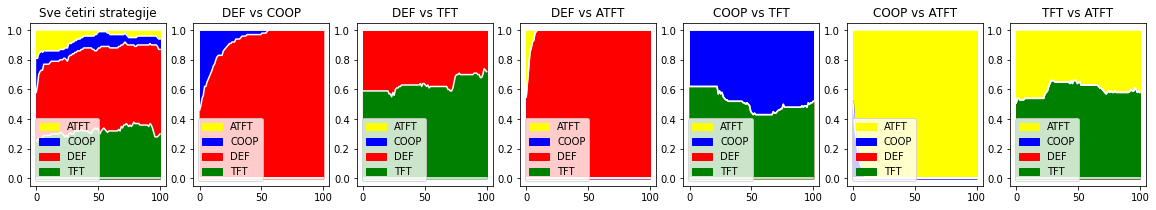

In [78]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(3)
plot_strategy_ratio(game_1, 1, 7, 1, 'Sve četiri strategije')
plot_strategy_ratio(game_2, 1, 7, 2, 'DEF vs COOP')
plot_strategy_ratio(game_3, 1, 7, 3, 'DEF vs TFT')
plot_strategy_ratio(game_4, 1, 7, 4, 'DEF vs ATFT')
plot_strategy_ratio(game_5, 1, 7, 5, 'COOP vs TFT')
plot_strategy_ratio(game_6, 1, 7, 6, 'COOP vs ATFT')
plot_strategy_ratio(game_7, 1, 7, 7, 'TFT vs ATFT')
plt.show()